## determining length of hexameric nucleosome loop to move upstream upon RNAP passage

In [1]:
import numpy as np
import matplotlib.pyplot as plt

dist oct  3.009745165939353
dist hex  2.1072219945225816
theta oct 89.0
theta hex 88.0
base oct 1.09
base hex 1.95


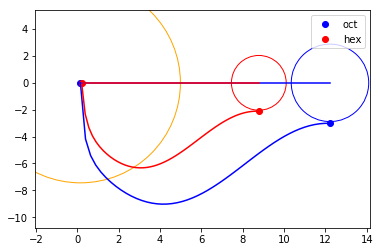

In [426]:
hexc = 'r'; octc = 'b'

Noct = 147
Nun = 40
Nhex = 107
# from "Structural analysis of the hexasome, lacking one histone H2A/H2B dimer from the conventional nucleosome."
roct = 2.06
rhex = 1.48

cloop = 1.5; bloop = 4.0/5; sloop = 2.0*cloop
def loop(x, r):
    return -cloop*r*np.sin(bloop*x/r) + 1.0/x - sloop*r

def dloop(x, r):
    return -cloop*bloop*np.cos(bloop*x/r) - 1.0/x**2

def ddloop(x, r):
    return cloop*bloop**2/r*np.sin(bloop*x/r) + 2.0/x**2

a = cloop*bloop; b = sloop*roct; c = -1
startoct = (-b + np.sqrt(b**2 - 4*a*c))/(2*a)
plt.plot(startoct, loop(startoct, roct), 'o'+ octc)

a = cloop*bloop; b = sloop*rhex; c = -1
starthex = (-b + np.sqrt(b**2 - 4*a*c))/(2*a)
plt.plot(starthex, loop(starthex, rhex), 'o' + hexc)

endoct = 2*roct*np.pi/bloop
xoct = np.linspace(1e-3, endoct)
stopoct = np.argmax(-cloop*roct*np.sin(bloop*xoct/roct) - sloop*roct)
stopoct = xoct[stopoct]
plt.plot(stopoct, loop(stopoct, roct), 'o'+ octc)

endhex = 2*rhex*np.pi/bloop
xhex = np.linspace(1e-3, endhex)
stophex = np.argmax(-cloop*rhex*np.sin(bloop*xhex/rhex) - sloop*rhex)
stophex = xhex[stophex]
plt.plot(stophex, loop(stophex, rhex), 'o' + hexc)

xoct = np.linspace(startoct, stopoct)
plt.plot(xoct, loop(xoct, roct), octc)

xhex = np.linspace(starthex, stophex)
plt.plot(xhex, loop(xhex, rhex), hexc)

plt.plot(xoct, np.ones(len(xoct))*0, octc)
plt.plot(xhex, np.ones(len(xhex))*0, hexc)
plt.ylim([-2*endoct/3.0, endoct/3.0])
plt.xlim([-endoct/8.0, 7*endoct/8.0])

print 'dist oct ', - loop(stopoct, roct)
print 'dist hex ', - loop(stophex, rhex)

plt.scatter(startoct, 0, s=40000, facecolors='none', edgecolors='orange')
plt.scatter(stopoct, 0, s=6000, facecolors='none', edgecolors='b')
plt.scatter(stophex, 0, s=3000, facecolors='none', edgecolors='r')

plt.legend(['oct', 'hex'])

print 'theta oct', np.round(np.arctan(-dloop(startoct, roct))*180/np.pi)
print 'theta hex', np.round(np.arctan(-dloop(starthex, rhex))*180/np.pi)

baseoct = (Noct/2.0 - Nun)/3.0
basehex = (Nhex/2.0 - Nun)/3.0

print 'base oct', round(stopoct/baseoct,2)
print 'base hex', round(stophex/basehex,2)

plt.show()

In [427]:
from scipy.integrate import quad

def integrand(x, r):
    return np.sqrt(1 + dloop(x, r)**2)

I = quad(integrand, startoct, stopoct, args = roct)
Loct = I[0] + stopoct 
print Loct, Loct*3

I = quad(integrand, starthex, stophex, args = rhex)
Lhex = I[0] + stophex  
print Lhex, Lhex*3

33.38092915231121 100.14278745693363
23.62084072016949 70.86252216050846


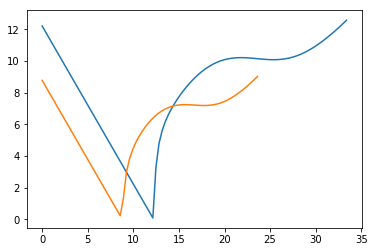

In [428]:
bpoct = int(Loct*3)
bphex = int(Lhex*3)

def rvec(s, L, r, start, stop):
    if s <= stop:
        x = stop-s; y = 0
    else:
        x = start + (stop-start)*(s-stop)/(L-stop); y = loop(x, r)
    return np.sqrt(x**2 + y**2)

x = np.linspace(0, Loct, bpoct)
ar = []
for i in x:
    ar.append(rvec(i, Loct, roct, startoct, stopoct))
plt.plot(x, ar)

x = np.linspace(0, Lhex, bphex)
ar = []
for i in x:
    ar.append(rvec(i, Lhex, rhex, starthex, stophex))
plt.plot(x, ar)

plt.show()

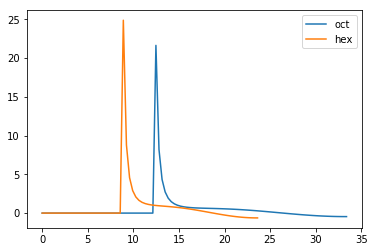

In [429]:
# second-order central differencing 
def cd2(s, L, r, start, stop):
    h = 1e-8 #best h for central differencing
    return (rvec(s + h, L, r, start, stop) - 2*rvec(s, L, r, start, stop) + rvec(s - h, L, r, start, stop))/h**2

def ancd2(s, L, r, start, stop):
    if s <= stop:
        d = 0
    else:
        x = start + (stop-start)*(s-stop)/(L-stop); d = ddloop(x, r)
    return d

l = np.linspace(0, Loct, bpoct)
dr2 = []
for i in l:
    dr2.append(ancd2(i, Loct, roct, startoct, stopoct))
plt.plot(l, dr2)

l = np.linspace(0, Lhex, bphex)
dr2 = []
for i in l:
    dr2.append(ancd2(i, Lhex, rhex, starthex, stophex))
plt.plot(l, dr2)

plt.legend(['oct', 'hex'])

plt.show()

In [430]:
N = 1e3; a = 0.0; boct = Loct; bhex = Lhex
hoct = (boct-a)/N
hhex = (bhex-a)/N
# determine odd sum 
k = np.linspace(1, N-1, int(N/2))
oddSumoct = 0; oddSumhex = 0
for i in k:
    oddSumoct += ancd2(a + i*hoct, Loct, roct, startoct, stopoct)
    oddSumhex += ancd2(a + i*hhex, Lhex, rhex, starthex, stophex)
# determine even sum
k = np.linspace(2, N-2, int(N/2) - 1)
evenSumoct = 0; evenSumhex = 0
for i in k:
    evenSumoct += ancd2(a + i*hoct, Loct, roct, startoct, stopoct)
    evenSumhex += ancd2(a + i*hhex, Lhex, rhex, starthex, stophex)
# find final area
integoct = 1.0/(3)*hoct *(ancd2(a, Loct, roct, startoct, stopoct) + ancd2(b, Loct, roct, startoct, stopoct) + 4*oddSumoct + 2*evenSumoct)
integhex = 1.0/(3)*hhex *(ancd2(a, Lhex, rhex, starthex, stophex) + ancd2(b, Lhex, rhex, starthex, stophex) + 4*oddSumhex + 2*evenSumhex)

print integoct, integhex

24.9868088142524 17.807316652562314


In [431]:
kB = 1.38e-23; T = 295
E = 2e9 # youngs modulus
I = (np.pi*(1e-9)**4)/4 # moment of inertia of rod
Bs = E*I
P = Bs/(kB*T)
print P*1e9/3

128.616746647


In [432]:
Etoroct = 0.5*kB*T*P*integoct
Etorhex = 0.5*kB*T*P*integhex
print Etoroct, Etorhex

1.962459375187701e-26 1.398583379395924e-26


In [433]:
kspringoct = 2*Etoroct/(1.0/(bpoct*3*1e-9))**2
kspringhex = 2*Etorhex/(1.0/(bphex*3*1e-9))**2

0.71 % error in scaled


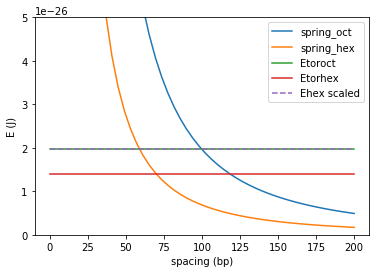

In [434]:
def Etrans(spc, kspring):
    return 0.5*kspring*(1.0/(spc*3*1e-9))**2

x = np.linspace(1e-4, 200)
plt.plot(x, Etrans(x, kspringoct))
plt.plot(x, Etrans(x, kspringhex))
#plt.plot(x, kB*T*np.ones(len(x)))
plt.plot(x, Etoroct*np.ones(len(x)))
plt.plot(x, Etorhex*np.ones(len(x)))
plt.plot(x, Loct/Lhex*Etorhex*np.ones(len(x)), '--')
plt.ylim([0, 5e-26])

plt.xlabel('spacing (bp)')
plt.ylabel('E (J)')

plt.legend(['spring_oct', 'spring_hex', 'Etoroct', 'Etorhex', 'Ehex scaled'])

print np.abs(round((Loct/Lhex*Etorhex - Etoroct)/(Etoroct)*100,2)), '% error in scaled'

plt.show()